In [ ]:
!pip install qiskit
!pip install pylatexenc

from IPython.display import clear_output
clear_output(wait=False)

In [ ]:
from qiskit import *
import random
import numpy as np
from scipy.linalg import expm
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_qsphere
from qiskit.extensions import UnitaryGate
from qiskit.extensions import Initialize
from qiskit.visualization import array_to_latex

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
svsim = Aer.get_backend('statevector_simulator')

Hamiltonian matrix: 
 [[0 1]
 [1 0]]
--------------------------------------------------------
U matrix:
 [[-1.-0.00000000e+00j  0.-2.35127499e-16j]
 [ 0.-2.35127499e-16j -1.-0.00000000e+00j]]
Base Circuit:
              ┌───┐                          
q_0: ─────────┤ H ├─────────────────■────────
     ┌────────┴───┴────────┐┌───────┴───────┐
q_1: ┤ En(0.70711,0.70711) ├┤ U = exp(-iHt) ├
     └─────────────────────┘└───────────────┘
Base Circuit Counts {'00': 0.25, '01': 0.25, '10': 0.25, '11': 0.25}


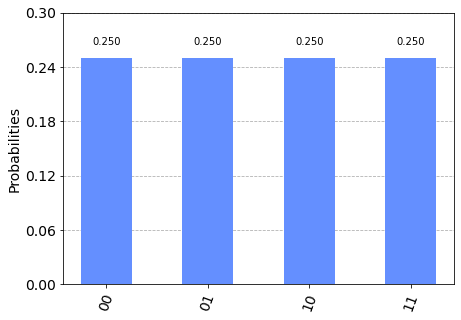

In [ ]:
from qiskit.visualization import array_to_latex
H = [[0, 1],                                  #Operator whose eigenvalues and eigenvectors are to be found 
     [1,0]] 
H = np.matrix(H)  
print("Hamiltonian matrix: \n", H)
print("--------------------------------------------------------")

t = np.pi                                  
U = expm(-1j * H * t)
print("U matrix:\n", U)

En = [1/np.sqrt(2),1/np.sqrt(2)]

base_circuit = QuantumCircuit(2)

eigstate = Initialize(En)
eigstate.label = "En"
base_circuit.append(eigstate,[1])
base_circuit.h(0)

Ugate = UnitaryGate(U, label = "U = exp(-iHt)")
CUgate = Ugate.control(1)

base_circuit.append(CUgate, [0,1])

# SSML = Initialize(En)
# SSML.label = "SSML"
# base_circuit.append(SSML,[0])

print("Base Circuit:")
print(base_circuit)

result_base = execute(base_circuit, backend = svsim).result()
counts_base = result_base.get_counts()
state_base = result_base.get_statevector(base_circuit)
#print("State vector of Base Circuit \n", state_base)



print("Base Circuit Counts", counts_base)
plot_histogram(counts_base)
#array_to_latex(state_base, prefix="\\text{Statevector After Base Circuit} = ")

In [ ]:
#SSML on qubit 0

param_theta = random.random() * np.pi    #Angle for Unitary gate U(phi)
param_phi = random.random() * 2* np.pi

#Parameters for weight w
alpha = 0.5
beta = 0.6

Ms = 0 
Mh = 200

while Ms < Mh :
  circuit = QuantumCircuit(2,2)
  circuit = circuit + base_circuit
  # print("Start circuit")
  # print(circuit)
  circuit.u(-param_theta,0, -param_phi,0)
  circuit.measure(0,0)
  result = execute(circuit, backend = simulator, shots = 1).result()
  result_dict = result.get_counts()
  measurement_output = int(list(result_dict.keys())[list(result_dict.values()).index(1)])
  # print(measurement_output)
  # print(type(measurement_output))

  #success
  if measurement_output == 0 :
    Ms = Ms + 1 
    # print("success")
  
  #failure
  elif measurement_output == 1 : 
    # print("fail")
    w = alpha * (Ms + 1)**(-beta)
    r1 = random.choice((-1, 1)) * random.random() * np.pi
    r2 = random.choice((-1, 1)) * random.random() * 2* np.pi 
    Ms = 0 
    param_theta = (param_theta + w * r1) % (np.pi)
    param_phi = (param_phi + w * r2) % (2*np.pi)

  # print("end circuit")
  # print(base_circuit)

print("Final Parameters: ")
print("Theta:",param_theta)
print("Phi",param_phi)

final_circuit = base_circuit
final_circuit.u(-param_theta,0, -param_phi,0)
print("Final Circuit : Should give fiducial state on qubit 0")
print(final_circuit)

res_fiducial = execute(final_circuit, backend=svsim).result()
fiducial_state = res_fiducial.get_statevector(final_circuit)
fiducial_counts = res_fiducial.get_counts()
print("Observed State (should be fiducial theoretically):\n", fiducial_state)
print("counts", fiducial_counts)
plot_histogram(fiducial_counts)
array_to_latex(fiducial_state, prefix="\\text{State observed} = ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  from ipykernel import kernelapp as app


Final Parameters: 
Theta: 1.4070815435336583
Phi 3.1432153213214225
Final Circuit : Should give fiducial state on qubit 0
              ┌───┐                          ┌──────────────────────┐
q_0: ─────────┤ H ├─────────────────■────────┤ U(-1.4071,0,-3.1432) ├
     ┌────────┴───┴────────┐┌───────┴───────┐└──────────────────────┘
q_1: ┤ En(0.70711,0.70711) ├┤ U = exp(-iHt) ├────────────────────────
     └─────────────────────┘└───────────────┘                        
Observed State (should be fiducial theoretically):
 Statevector([0.70473865-0.00052487j, 0.0578168 -0.00061869j,
             0.70473865-0.00052487j, 0.0578168 -0.00061869j],
            dims=(2, 2))
counts {'00': 0.496656835384543, '01': 0.003343164615456, '10': 0.496656835384543, '11': 0.003343164615456}


<IPython.core.display.Latex object>

Estimated State: 
 Statevector([ 0.76255637+0.j        , -0.64692092-0.00104974j],
            dims=(2,))
{'0': 0.581492217151635, '1': 0.418507782848365}


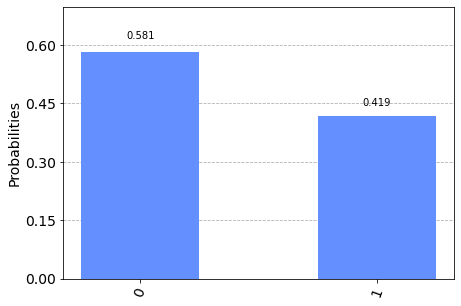

In [ ]:
estimation_circuit = QuantumCircuit(1)
estimation_circuit.u(param_theta, param_phi,0,0)

res_est = execute(estimation_circuit, backend=svsim).result()
res_state = res_est.get_statevector(estimation_circuit)
res_counts = res_est.get_counts()
print("Estimated State: \n", res_state)
print(res_counts)
plot_histogram(res_counts)


In [ ]:
print(param_phi)
En = param_phi/t
print("Eigenvalue=",En)

3.1432153213214225
Eigenvalue= 1.000516511180969
